## Rafał Pieńkosz rp76745

# Python Script for master thesis: "Rozpoznawanie tekstu przy użyciu metod optycznego rozpoznawania znaków (OCR)". Implementation of OCR algorithm.

In [15]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras_tuner
from keras_tuner import RandomSearch

import tensorflow as tf
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV

from spellchecker import SpellChecker

## 1. Load and view data

In [16]:
train = pd.read_csv("C:/Users/rafal/Desktop/Praca_magisterska/written_name_train_v2.csv")
valid = pd.read_csv("C:/Users/rafal/Desktop/Praca_magisterska/written_name_validation_v2.csv")
test = pd.read_csv("C:/Users/rafal/Desktop/Praca_magisterska/written_name_test_v2.csv")

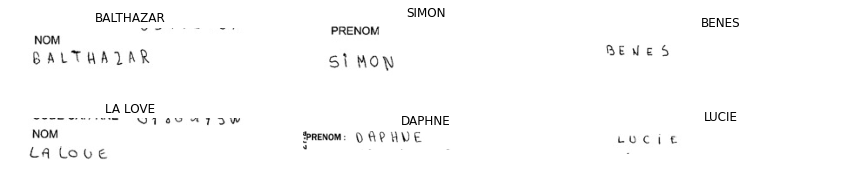

In [17]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = "C:/Users/rafal/Desktop/Praca_magisterska/train_v2/train/"+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## 2. Cleaning Data

Let's check for NaNs in our label.

In [18]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

## 3. Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y). 
* The image is then normalized to range [0, 1]

In [19]:
def preprocess_images(train_size, valid_size):
    
    def preprocess(img):
        (h, w) = img.shape

        final_img = np.ones([64, 256])*255 # blank white image

        # crop
        if w > 256:
            img = img[:, :256]

        if h > 64:
            img = img[:64, :]

        final_img[:h, :w] = img
        return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

    # set the train and valid size - hyperparameter tuning will be perform on 3000 images and validate on 1000 images
    train_size = train_size
    valid_size= valid_size
    
    train_x = []

    for i in range(train_size):
        img_dir = "C:/Users/rafal/Desktop/Praca_magisterska/train_v2/train/"+train.loc[i, 'FILENAME']
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        image = preprocess(image)
        image = image/255.
        train_x.append(image)
        
    valid_x = []

    for i in range(valid_size):
        img_dir = "C:/Users/rafal/Desktop/Praca_magisterska/validation_v2/validation/"+valid.loc[i, 'FILENAME']
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        image = preprocess(image)
        image = image/255.
        valid_x.append(image)
    
    train_x = np.array(train_x).reshape(-1, 256, 64, 1)
    valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
    
    return train_x, valid_x

In [6]:
train_x, valid_x = preprocess_images(3000, 1000)

## 4. Preparing the labels for CTC Loss

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [21]:
def preprocess_ctc(train_size, valid_size):

    train_size = train_size
    valid_size= valid_size

    alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
    max_str_len = 24 # max length of input labels
    num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
    num_of_timestamps = 64 # max length of predicted labels

    def label_to_num(label):
        label_num = []
        for ch in label:
            label_num.append(alphabets.find(ch))

        return np.array(label_num)

    def num_to_label(num):
        ret = ""
        for ch in num:
            if ch == -1:  # CTC Blank
                break
            else:
                ret+=alphabets[ch]
        return ret

    train_y = np.ones([train_size, max_str_len]) * -1
    train_label_len = np.zeros([train_size, 1])
    train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
    train_output = np.zeros([train_size])

    for i in range(train_size):
        train_label_len[i] = len(train.loc[i, 'IDENTITY'])
        train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

    valid_y = np.ones([valid_size, max_str_len]) * -1
    valid_label_len = np.zeros([valid_size, 1])
    valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
    valid_output = np.zeros([valid_size])

    for i in range(valid_size):
        valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
        valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    
        
    return train_y, train_label_len, train_input_len, train_output, valid_y, valid_label_len, valid_input_len, valid_output

In [ ]:
train_y, train_label_len, train_input_len, train_output, valid_y, valid_label_len, valid_input_len, valid_output = preprocess_ctc(3000, 1000)

* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss. 


## 5. Building the model


### 5a. Hyper parameter tuning - selecting the best model

In [17]:
# define the model architecture together with CTC loss 
def run_model(hp):

    alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
    max_str_len = 24 # max length of input labels
    num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
    num_of_timestamps = 64
    
    input_data = Input(shape=(256, 64, 1), name='input')

    inner = Conv2D(hp.Int("conv_1_units", min_value=32, max_value=128, step=32), hp.Choice('conv_1_kernel', values = [3,5]), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

    inner = Conv2D(hp.Int("conv_2_units", min_value=32, max_value=128, step=32), hp.Choice('conv_2_kernel', values = [3,5]), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
    inner = Dropout(0.3)(inner)

    inner = Conv2D(128, hp.Choice('conv_3_kernel', values = [3,5]), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
    inner = Dropout(0.3)(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    ## RNN
    inner = Bidirectional(LSTM(hp.Int('lstm_1_units',min_value=128, max_value=256, step=128), return_sequences=True), name = 'lstm1')(inner)
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

    ## OUTPUT
    inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
    y_pred = Activation('softmax', name='softmax')(inner)

    model = Model(inputs=input_data, outputs=y_pred)
    #model.summary()
    
    # the ctc loss function
    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        y_pred = y_pred[:, 2:, :]
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    
    labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
    
    random.seed(100)
    
    # the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
    model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(hp.Choice('learning_rate', values=[0.001, 0.0001])))
  
    
    return model_final

In [18]:
# Seacrh for best hyperparameters
tuner = RandomSearch(run_model,
                    objective='val_loss',
                    max_trials = 2,
                    overwrite=True)

tuner.search(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output))

Trial 2 Complete [00h 07m 38s]
val_loss: 21.762157440185547

Best val_loss So Far: 21.004289627075195
Total elapsed time: 00h 20m 18s
INFO:tensorflow:Oracle triggered exit


In [19]:
# summary of search - parameters
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
lstm_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
#summary of best model
model_new=tuner.get_best_models(num_models=1)[0]
model_new.summary()
model_new.save("CRNN")

In [37]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 64, 128  1280        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 64, 128  512        ['conv1[0][0]']                  
 alization)                     )                                                           

### 5b. Train final model using best hyperparameters

In [24]:
train_x, valid_x = preprocess_images(30000, 10000)

In [25]:
train_y, train_label_len, train_input_len, train_output, valid_y, valid_label_len, valid_input_len, valid_output = preprocess_ctc(30000, 10000)

In [29]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(128, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(96, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)


# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

filepath="best_model_new.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 128)      1280      
                                                                 
 batch_normalization_6 (Batc  (None, 256, 64, 128)     512       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 256, 64, 128)      0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 128)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 96)       110688    
                                                           

In [ ]:
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=50, batch_size=128, callbacks = callbacks_list)

Epoch 1/50
220/235 [===========================>..] - ETA: 5:11 - loss: 24.2115

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

## 7. Check model performance on train and validation set

In [ ]:
#model.load_weights('best_model.hdf5')
model.load_weights('best_model_new.hdf5')
print("[INFO] loading OCR model...")

### Define evaluate function

In [ ]:
def calculate_correct(true, prediction, size):
    
    correct_char = 0
    total_char = 0
    correct = 0
    correct2 = 0

    wrong_true = []
    wrong_prediction = []

    for i in range(size):
        pr = prediction[i]
        tr = true[i]
        total_char += len(tr)

        for j in range(min(len(tr), len(pr))):
            if tr[j] == pr[j] or tr[-j] == pr[-j]:
                correct_char += 1

        if pr == tr:
            correct += 1
        elif tr == pr[1:20]:
            correct2 += 1
        else:    
            wrong_true.append(true[i]), wrong_prediction.append(prediction[i])

        correct_character = round(correct_char*100/total_char,2)
        correct_word = round(correct*100/size,2)
        correct_word2 = round((correct+correct2)*100/size,2)

    print('Correct characters predicted :', correct_character,'%')
    print('Correct words predicted :', correct_word,'%')
    print('Correct words predicted (with additional false first letter) :', correct_word2,'%')
    print('\nWrong words predicted :', round(100-correct_word,2),'%')

    perc_correct_char = []
    nr_wrong_char = []
    
    for i in range(len(wrong_true)):
        pr = wrong_prediction[i]
        tr = wrong_true[i]
        nr_correct = 0

        for j in range(min(len(tr), len(pr))):
            if tr[j] == pr[j] or tr[-j] == pr[-j]:
                nr_correct += 1

        correct_char_in_word = nr_correct/((len(tr)+len(pr))/2)
        nr_wrong = ((len(tr)+len(pr))/2) - nr_correct
        perc_correct_char.append(correct_char_in_word)
        nr_wrong_char.append(nr_wrong)
        
    table = pd.DataFrame(
        {'True': wrong_true,
         'Predicted': wrong_prediction,
         'perc_correct': perc_correct_char,
         'nr_wrong': nr_wrong_char,
        })
    
    
    table['Perc bands'] = np.where(table['perc_correct'] >= 0.9, '>= 90 %',
                                   np.where(table['perc_correct'] >= 0.8, '< 90 %',
                                   np.where(table['perc_correct'] >= 0.7, '< 80 %',
                                   np.where(table['perc_correct'] >= 0.6, '< 70 %',
                                   np.where(table['perc_correct'] >= 0.5, '< 60 %',
                                   np.where(table['perc_correct'] >= 0.4, '< 50 %',
                                   np.where(table['perc_correct'] >= 0.3, '< 40 %',
                                   np.where(table['perc_correct'] >= 0.2, '< 30 %',
                                   np.where(table['perc_correct'] >= 0.1, '< 20 %', '< 10 %')))))))))
    table['nr wrong'] = np.where(table['nr_wrong'] <= 1, '1',
                                   np.where(table['nr_wrong'] == 2, '2',
                                   np.where(table['nr_wrong'] == 3, '3',
                                   np.where(table['nr_wrong'] == 4, '4', '>= 5'))))
    #table['literowka'] = np.where((table['perc_correct'] >= 0.5) & (table['nr_wrong'] <= 1), 1,0)
    table['literowka'] = np.where((table['perc_correct'] >= 0.90) | (table['nr_wrong'] <= 1), 1,0)
    perc = pd.DataFrame(table['Perc bands'].value_counts().sort_index(ascending=False))
    perc['%'] = round(perc['Perc bands']/ len(table),2)
    perc_number = pd.DataFrame(table['nr wrong'].value_counts().sort_index(ascending=True))
    perc_number['%'] = round(perc_number['nr wrong']/ len(table),2)
    perc_number['% total'] = round(perc_number['nr wrong']/ size,2)
    literowka = pd.DataFrame(table['literowka'].value_counts().sort_index(ascending=True))
    literowka['%'] = round(literowka['literowka']/ len(table),2)
    literowka['% total'] = round(literowka['literowka']/ size,2)
    print('\nWrong words predictions diagnostics - correct character percent bands:')
    
    #return literowka
    #return perc
    return perc_number

In [ ]:
a = model.predict(train_x)

### Train prediction and evaluation

In [36]:
train_size=30000
y_true_train = train.loc[0:train_size, 'IDENTITY']
preds = model.predict(train_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction_train = []
for i in range(train_size):
    prediction_train.append(num_to_label(decoded[i]))    

ValueError: in user code:

    File "C:\Users\rafal\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\rafal\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\rafal\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\rafal\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\rafal\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\rafal\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 256, 64, 1) dtype=float32>]


In [ ]:
calculate_correct(y_true_train, prediction_train, train_size)

### Valid prediction and evaluation

In [22]:
valid_size=10000
y_true_valid = valid.loc[0:valid_size, 'IDENTITY']
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction_valid = []
for i in range(valid_size):
    prediction_valid.append(num_to_label(decoded[i]))    

In [23]:
calculate_correct(y_true_valid, prediction_valid, valid_size)

Correct characters predicted : 92.97 %
Correct words predicted : 67.58 %
Correct words predicted (with additional false first letter) : 75.38 %

Wrong words predicted : 32.42 %

Wrong words predictions diagnostics - correct character percent bands:


,nr wrong,%,% total
1,1500,0.61,0.15
2,142,0.06,0.01
3,67,0.03,0.01
4,49,0.02,0.00
>= 5,704,0.29,0.07


## 8. Check model performance on test set

In [24]:
test_size= 10000
test_x = []

for i in range(test_size):
    img_dir = "C:/Users/rafal/Desktop/Praca_magisterska/test_v2/test/"+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)
    
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY'])    

In [25]:
y_true_test = test.loc[0:test_size, 'IDENTITY']
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction_test = []
for i in range(test_size):
    prediction_test.append(num_to_label(decoded[i]))    

In [26]:
calculate_correct(y_true_test, prediction_test, test_size)

Correct characters predicted : 92.31 %
Correct words predicted : 66.82 %
Correct words predicted (with additional false first letter) : 74.29 %

Wrong words predicted : 33.18 %

Wrong words predictions diagnostics - correct character percent bands:


,nr wrong,%,% total
1,1488,0.58,0.15
2,158,0.06,0.02
3,74,0.03,0.01
4,58,0.02,0.01
>= 5,793,0.31,0.08


### Prediction on example test data

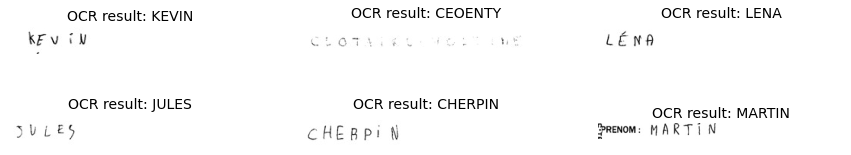

In [27]:
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/rafal/Desktop/Praca_magisterska/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title('OCR result: '+str(num_to_label(decoded[0])), fontsize=14)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Ways to improve the model 

* Use more training samples. This will help the model to learn and generalise better. I have used only 10% of the images as the entire training set cannot be loaded into kaggle's memory. 
* There are multiple images in the training set which are not at all legible to the human eye. Removing such images will help in model's learning. 

## 9. Test model on new data and compare with other models

In [ ]:
import pytesseract
import keras_ocr
import easyocr

#### LOAD IMAGES

In [74]:
image1 = cv2.imread(r"C:\Users\rafal\Desktop\Praca_magisterska\image1.jpg", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(r"C:\Users\rafal\Desktop\Praca_magisterska\image2.jpg", cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread(r"C:\Users\rafal\Desktop\Praca_magisterska\image3.jpg", cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread(r"C:\Users\rafal\Desktop\Praca_magisterska\image4.jpg", cv2.IMREAD_GRAYSCALE)
image5 = cv2.imread(r"C:\Users\rafal\Desktop\Praca_magisterska\image5.jpg", cv2.IMREAD_GRAYSCALE)
image6 = cv2.imread(r"C:\Users\rafal\Desktop\Praca_magisterska\image6.jpg", cv2.IMREAD_GRAYSCALE)

In [60]:
def preprocess_test(img):
    
    kernel = np.ones((5,5),np.uint8)
    img = cv2.dilate(img,kernel,iterations = 1)
    (h, w) = image.shape
    aspect_ratio = h/w
    h_n = 64
    w_n = h_n/aspect_ratio
    dim =(round(w_n), h_n)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    img = resized
    
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
       
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

## Prediction using built CRNN

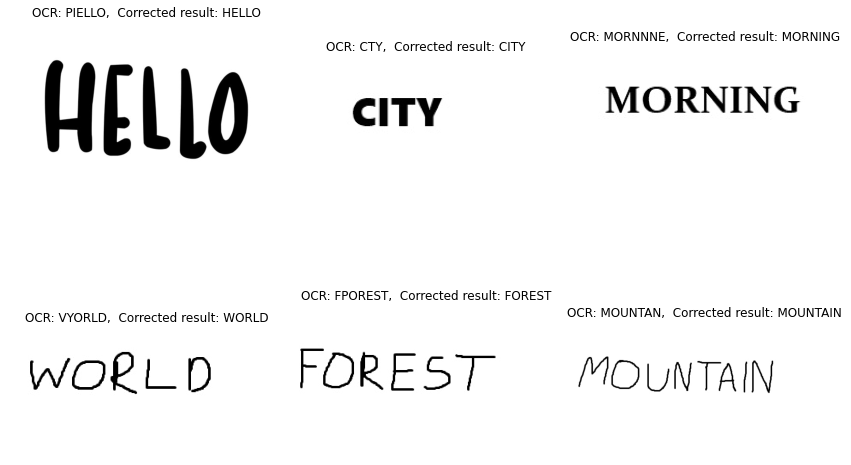

In [77]:
images = [image1, image2, image3, image4, image5, image6]

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    
    image = images[i]
    plt.imshow(image, cmap='gray')  
    image = preprocess_test(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                           greedy=True)[0][0])

    predict = num_to_label(decoded[0])
    spell = SpellChecker()
    corrected = spell.correction(predict).upper()
    
    plt.title('OCR: '+str(predict)+',  Corrected result: '+str(corrected), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)

In [17]:
def run_model_test():

    input_data = Input(shape=(256, 64, 1), name='input')

    inner = Conv2D(32, (3,3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

    inner = Conv2D(64, (3,3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
    inner = Dropout(0.3)(inner)

    inner = Conv2D(128, (3,3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
    inner = Dropout(0.3)(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    ## RNN
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

    ## OUTPUT
    inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
    y_pred = Activation('softmax', name='softmax')(inner)

    model = Model(inputs=input_data, outputs=y_pred)
    #model.summary()
    
    # the ctc loss function
    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        # the 2 is critical here since the first couple outputs of the RNN
        # tend to be garbage
        y_pred = y_pred[:, 2:, :]
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    
    labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
    
    random.seed(100)
    
    # the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
    model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(hp.Choice('learning_rate', values=[0.001, 0.0001])))
  
    
    return model_final